In [2]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
image_path = 'mechanical1.png'
image = cv2.imread(image_path)
intensity_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
threshold_value = 128
image_array = np.array(intensity_image)
binary_image = (image_array > threshold_value).astype(np.uint8) * 255
print(len(image_array), len(image_array[0]))

1822 566


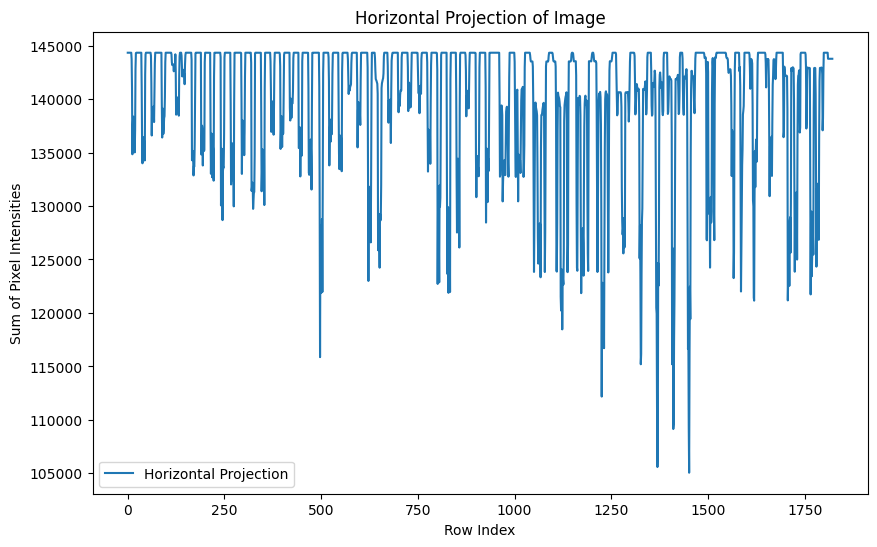

In [3]:
# Compute horizontal projection (sum of pixel intensities along rows)
horizontal_projection = np.sum(image_array, axis=1)

# Plot the horizontal projection
plt.figure(figsize=(10, 6))
plt.plot(horizontal_projection, label='Horizontal Projection')
plt.xlabel('Row Index')
plt.ylabel('Sum of Pixel Intensities')
plt.title('Horizontal Projection of Image')
plt.legend()
plt.show()

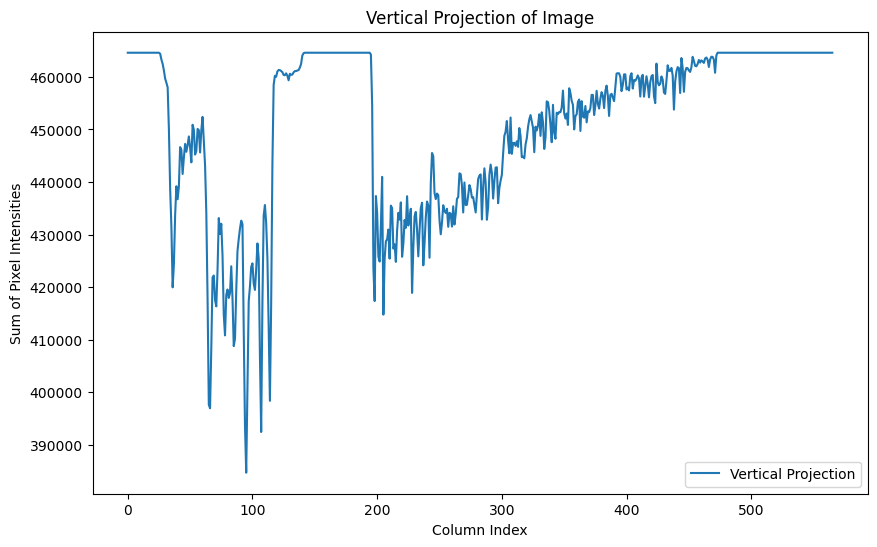

In [4]:
# Compute vertical projection (sum of pixel intensities along columns)
vertical_projection = np.sum(image_array, axis=0)

# Plot the vertical projection
plt.figure(figsize=(10, 6))
plt.plot(vertical_projection, label='Vertical Projection')
plt.xlabel('Column Index')
plt.ylabel('Sum of Pixel Intensities')
plt.title('Vertical Projection of Image')
plt.legend()
plt.show()

In [35]:
def row_segmentation(horizontal_projection, horizontal_threshold):
    row_segments = []
    # Find row indices where projection exceeds the threshold
    row_indices = np.where(horizontal_projection > horizontal_threshold)[0]

    start = row_indices[0]
    for i in range(1, len(row_indices)):
        if row_indices[i] != row_indices[i - 1] + 1:
            row_segments.append((start, row_indices[i]))
            start = row_indices[i]
    row_segments.append((start, row_indices[-1]))

In [36]:
from scipy.signal import find_peaks

# Use peak detection to identify significant rows
def peak_based_row_segmentation(projection, prominence=500, distance=20):
    """
    Use peak detection to find significant rows based on local maxima.
    """
    peaks, _ = find_peaks(projection, prominence=prominence, distance=distance)
    segments = [(peak, peak) for peak in peaks]  # Treat each peak as a row
    return segments

In [55]:
# Correcting the adaptive row segmentation to include peak widths
def adaptive_peak_based_row_segmentation_fixed(projection, prominence=2000, distance=20, horizontal_threshold = None):
    """
    Dynamically adapts to varying row heights by detecting peaks and grouping them.
    """
    peaks, properties = find_peaks(projection, prominence=prominence, distance=distance)
    segments = []
    current_start = peaks[0]

    for i in range(1, len(peaks)):
        # If the gap between peaks is larger than the previous peak's width, start a new segment
        # if peaks[i] - peaks[i - 1] > properties["widths"][i - 1]:
        if horizontal_projection[peaks[i]] > horizontal_threshold:
            segments.append((current_start, peaks[i]))
            current_start = peaks[i]
    
    # Add the last segment
    segments.append((current_start, peaks[-1]))
    return segments


In [74]:
# Implementing row segmentation based on counting non-white pixels
def white_pixel_based_row_segmentation(binary_image, threshold=0, distance = 20):
    """
    Segments rows by identifying lines where all pixels are white (255).
    """
    row_sums = np.sum(binary_image < 255, axis=1)  # Count non-white pixels in each row
    row_indices = np.where(row_sums <= threshold)[0]  # Identify rows with all white pixels
    segments = []

    start = row_indices[0]
    for i in range(1, len(row_indices)):
        if row_indices[i] != row_indices[i - 1] + 1 and row_indices[i] - start > distance:
            segments.append((start, row_indices[i]))
            start = row_indices[i]
    segments.append((start, row_indices[-1]))
    
    return segments


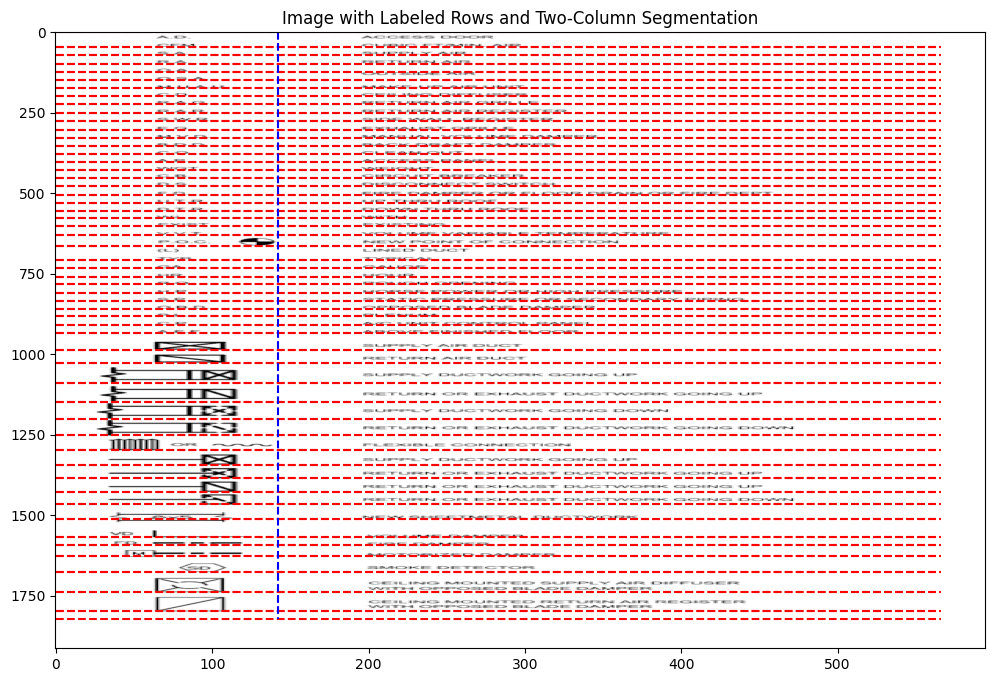

54


In [75]:
# Find where to start looking for the vertical 
mean_value_index = np.argmin(vertical_projection >= np.mean(vertical_projection))

# Find the maximum intensity index after the mean value index
max_intensity_index = np.argmax(vertical_projection[mean_value_index:]) + mean_value_index


# Split the image into two columns at the point of minimum intensity
column_split = max_intensity_index

# Segment rows with the same logic, but use horizontal projection as before
horizontal_threshold = np.mean(horizontal_projection)

# Segment rows
row_segments = []

row_segments = row_segmentation(horizontal_projection, horizontal_threshold)
# Visualize the labeled rows and two-column segmentation
plt.figure(figsize=(12, 8))
plt.imshow(image_array, cmap='gray', aspect='auto')

# row_segments = peak_based_row_segmentation(horizontal_projection, 
#                                                       prominence=2000, 
#                                                       distance=20)

# row_segments = adaptive_peak_based_row_segmentation_fixed(horizontal_projection, 
#                                                                           prominence=2000, 
#                                                                           distance=15, horizontal_threshold = horizontal_threshold)

# Apply the white-pixel-based segmentation
row_segments = white_pixel_based_row_segmentation(binary_image, threshold=0)


# Draw row labels
for row in row_segments:
    plt.hlines(y=row, xmin=0, xmax=image_array.shape[1], colors='red', linestyles='dashed')

# Draw column split line
plt.vlines(x=column_split, ymin=0, ymax=image_array.shape[0], colors='blue', linestyles='dashed')

plt.title("Image with Labeled Rows and Two-Column Segmentation")
plt.savefig("segmentation3.png")
plt.show()

In [83]:
# import pytesseract
# from pathlib import Path
# # Ensure output directories exist
# output_dir = Path("extracted_symbols")
# output_dir.mkdir(exist_ok=True)
# symbols = []
# descriptions = []
# for i, (start_row, end_row) in enumerate(row_segments):
#     # Extract the row
#     row_image = intensity_image[start_row:end_row, :]

#     # Split the row into two columns using the previously identified column split
#     first_column = row_image[:, :column_split]
#     second_column = row_image[:, column_split:]

#     # Save the symbol (first column) as an image
#     symbol_path = output_dir / f"symbol_{i + 1}.png"
#     cv2.imwrite(str(symbol_path), first_column)
#     symbols.append(symbol_path)

#     # Recognize text in the second column using Tesseract OCR
#     recognized_text = pytesseract.image_to_string(second_column, config="--psm 6")
#     descriptions.append(recognized_text.strip())

# # Save results into a structured format
# import pandas as pd

# results = pd.DataFrame({
#     "Symbol Image Path": symbols,
#     "Description": descriptions
# })
# from IPython.display import display
# display(results)

<class 'ModuleNotFoundError'>: No module named 'pytesseract'

In [84]:
# Re-import necessary modules and try using EasyOCR as an alternative OCR library
import easyocr

# Initialize EasyOCR reader
reader = easyocr.Reader(['en'])

# Extract features again using EasyOCR for text recognition
symbols_easyocr = []
descriptions_easyocr = []

for i, (start_row, end_row) in enumerate(row_segments_white_pixel):
    # Extract the row
    row_image = binary_image[start_row:end_row, :]

    # Split the row into two columns using the previously identified column split
    first_column = row_image[:, :column_split]
    second_column = row_image[:, column_split:]

    # Check if the first column is empty
    if first_column.size > 0 and np.any(first_column < 255):  # Non-empty and not all white
        # Save the symbol (first column) as an image
        symbol_path = output_dir / f"symbol_easyocr_{i + 1}.png"
        cv2.imwrite(str(symbol_path), first_column)
        symbols_easyocr.append(str(symbol_path))
    else:
        symbols_easyocr.append(None)  # Append None for empty symbols

    # Check if the second column is non-empty
    if second_column.size > 0 and np.any(second_column < 255):  # Non-empty and not all white
        # Recognize text in the second column using EasyOCR
        recognized_text = reader.readtext(second_column, detail=0)
        descriptions_easyocr.append(" ".join(recognized_text).strip())
    else:
        descriptions_easyocr.append("")  # Append empty string for empty descriptions

# Save results into a structured format
results_easyocr = pd.DataFrame({
    "Symbol Image Path": symbols_easyocr,
    "Description": descriptions_easyocr
})

# Display the results
print("Extracted Symbols and Descriptions using EasyOCR:")
print(results_easyocr.head(10))  # Show the first 10 rows as an example

# Save to a CSV file for review
csv_output_path_easyocr = "/mnt/data/extracted_symbols_and_descriptions_easyocr.csv"
results_easyocr.to_csv(csv_output_path_easyocr, index=False)

print(f"EasyOCR results have been saved to: {csv_output_path_easyocr}")


<class 'ModuleNotFoundError'>: No module named 'easyocr'